# Tugas 1

## CNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [25]:
# transform  = transforms.ToTensor()

transform  = transforms.Compose([
                                 transforms.Lambda(lambda image: image.convert('RGB')),
                                 transforms.ToTensor(),
                                #  transforms.Resize((64,64)),
                                 transforms.ColorJitter(brightness=(0.5,1.5), contrast=(1), saturation=(0.5,1.5), hue=(-0.1,0.1)),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

In [26]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [27]:
print(train_data)
print()
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: Compose(
               Lambda()
               ToTensor()
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.0, 2.0), saturation=(0.5, 1.5), hue=(-0.1, 0.1))
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: Compose(
               Lambda()
               ToTensor()
               ColorJitter(brightness=(0.5, 1.5), contrast=(0.0, 2.0), saturation=(0.5, 1.5), hue=(-0.1, 0.1))
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [30]:
image,label = train_data[0]
image = transforms.functional.to_pil_image(image)
print(label)

5


AxesImage(size=(28, 28))


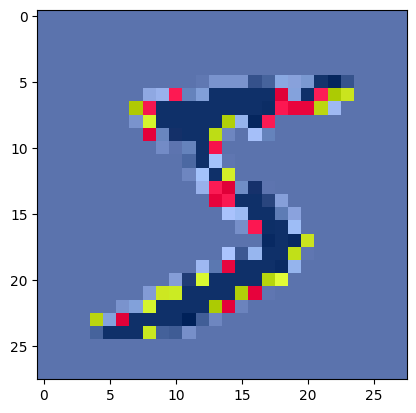

In [34]:
print(plt.imshow(image))

In [66]:
torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [67]:
class ConvMNIST(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,16,3,1)
    self.conv2 = nn.Conv2d(16,32,3,1)
    self.conv2_bn = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(5*5*32, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

    self.dropout = nn.Dropout(.4)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)
    x = self.conv2(x)
    x = self.conv2_bn(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2, 2)

    x = x.view(-1, 32*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)

    return F.log_softmax(x, dim=1)

In [68]:
torch.manual_seed(42)

device = torch.device("cpu")
model = ConvMNIST()
model.to(device)

ConvMNIST(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [70]:
import time

start_time = time.time()

epochs = 3
train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

for i in range(epochs):

  train_correct = 0
  for batch, (X_train, y_train) in enumerate(train_loader):
    batch+=1

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_correct = (predicted==y_train).sum()
    train_correct+=batch_correct

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%256 == 0:
      print(f"Epoch {i+1} Batch {batch} loss: {loss.item()}")

  train_losses.append(loss)
  train_corrects.append(train_correct)
  
  test_correct = 0
  with torch.no_grad():
    for batch, (X_test, y_test) in enumerate(test_loader):
      
      X_test = X_test.to(device)
      y_test = y_test.to(device)

      y_val = model(X_test)

      predicted = torch.max(y_val.data,1)[1]

      test_correct+=(predicted==y_test).sum()
  
  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_corrects.append(test_correct)

current_time = time.time()
total = current_time - start_time
print(f"Training finished in {total/60} minutes")

Epoch 1 Batch 256 loss: 0.26699596643447876
Epoch 2 Batch 256 loss: 0.054934076964855194
Epoch 3 Batch 256 loss: 0.06997808068990707
Training finished in 4.086551503340403 minutes


In [71]:
for i in range(len(train_losses)):
  train_losses[i] = train_losses[i].detach().numpy()

for i in range(len(test_losses)):
  test_losses[i] = test_losses[i].detach().numpy()

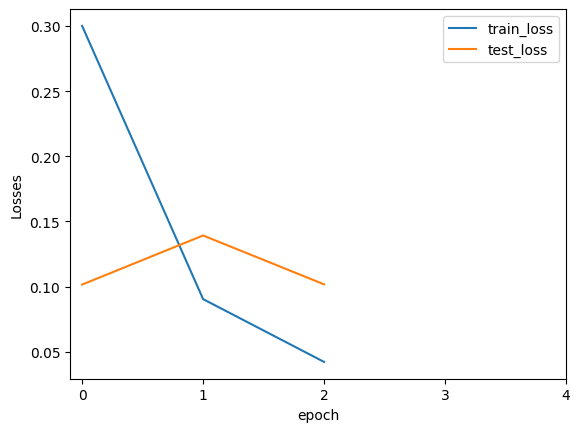

In [72]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.ylabel('Losses')
plt.xlabel('epoch')
plt.xticks(range(0,5))
plt.legend()

In [73]:
torch.manual_seed(42)
test_loader_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [74]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_loader_all:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct+=(predicted==y_test).sum()

In [75]:
print(correct.item()/len(test_data))

0.972


In [76]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.97      0.98      0.97      1032
           3       0.94      0.99      0.96      1010
           4       0.94      0.99      0.96       982
           5       0.98      0.97      0.98       892
           6       0.98      0.97      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.99      0.93      0.96       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [77]:
print(confusion_matrix(y_test, predicted))

[[ 966    0    2    1    2    2    6    1    0    0]
 [   0 1114    5    3    8    1    3    1    0    0]
 [   1    2 1008    8    4    0    1    7    1    0]
 [   0    0    4  999    2    1    0    2    0    2]
 [   0    1    1    1  973    0    1    0    1    4]
 [   2    0    2   14    1  865    2    1    2    3]
 [   5    3    3    0   14    4  929    0    0    0]
 [   1    5    8    5    3    2    0  997    1    6]
 [   6    1    9   28   10    4    3    4  902    7]
 [   3    2    1    7   19    3    0    3    4  967]]


## AlexNet

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
transform  = transforms.Compose([
                                 transforms.Lambda(lambda image: image.convert('RGB')),
                                 transforms.Resize((64,64)),
                                 transforms.ToTensor()
])

# transform  = transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

In [ ]:
train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, download=False, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/train-images-idx3-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/train-labels-idx1-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/MNIST/raw



In [ ]:
print(train_data)
print()
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./Data
    Split: Train
    StandardTransform
Transform: Compose(
               Lambda()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: Compose(
               Lambda()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
image,label = train_data[0]
print(image.shape)
print(label)

torch.Size([3, 64, 64])
5


In [ ]:
torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
model.classifier[6] = nn.Linear(4096, 10)
model.classifier.add_module('7', nn.LogSoftmax(dim=1))
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = 'cpu'
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import time

start_time = time.time()

epochs = 1
train_losses = []
test_losses = []
train_corrects = []
test_corrects = []

for i in range(epochs):

  train_correct = 0
  for batch, (X_train, y_train) in enumerate(train_loader):
    batch+=1

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_correct = (predicted==y_train).sum()
    train_correct+=batch_correct

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%256 == 0:
      print(f"Epoch {i+1} Batch {batch} loss: {loss.item()}")

  train_losses.append(loss)
  train_corrects.append(train_correct)
  
  # test_correct = 0
  # with torch.no_grad():
  #   for batch, (X_test, y_test) in enumerate(train_loader):
      
  #     X_test = X_test.to(device)
  #     y_test = y_test.to(device)

  #     y_val = model(X_test)

  #     predicted = torch.max(y_val.data,1)[1]

  #     test_correct+=(predicted==y_test).sum()
  
  # loss = criterion(y_val, y_test)
  # test_losses.append(loss)
  # test_corrects.append(test_correct)

current_time = time.time()
total = current_time - start_time
print(f"Training finished in {total/60} minutes")

Epoch 1 Batch 256 loss: 0.4100075364112854
Epoch 1 Batch 512 loss: 0.434085875749588
Epoch 1 Batch 768 loss: 0.24821922183036804
Training finished in 5.386282277107239 minutes


In [ ]:
for i in range(len(train_losses)):
  train_losses[i] = train_losses[i].cpu().detach().numpy()

for i in range(len(test_losses)):
  test_losses[i] = test_losses[i].cpu().detach().numpy()

In [ ]:
print("train loss: ", train_losses)
print("test_loss : ", train_losses)

train loss:  [array(0.6843805, dtype=float32)]
test_loss :  [array(0.6843805, dtype=float32)]


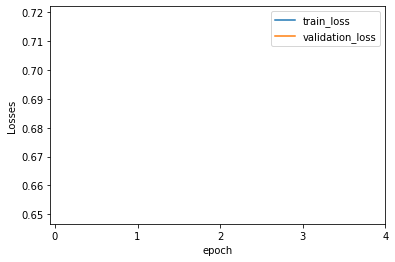

None


In [ ]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='validation_loss')
plt.ylabel('Losses')
plt.xlabel('epoch')
plt.xticks(range(0,5))
plt.legend()
print(plt.show())

In [ ]:
torch.manual_seed(42)
test_loader_all = DataLoader(test_data, batch_size=10000, shuffle=False)
test_loader_mini = DataLoader(test_data, batch_size=100, shuffle=False)

In [ ]:
preds = []

with torch.no_grad():
  correct = 0
  for batch, (X_test, y_test) in enumerate(test_loader_mini):
    batch+=1
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    preds.append(predicted)
    
    correct+=(predicted==y_test).sum()

In [ ]:
y_test = test_data.targets
y_test = y_test.numpy()

In [ ]:
y_pred = []

for batch_y in preds:
  for y_val in batch_y:
    y_pred.append(y_val)

for i in range(len(y_pred)):
  y_pred[i] = y_pred[i].cpu().detach().numpy()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       980
           1       0.97      0.99      0.98      1135
           2       0.85      0.82      0.84      1032
           3       0.81      0.87      0.84      1010
           4       0.95      0.84      0.89       982
           5       0.81      0.84      0.82       892
           6       0.86      0.94      0.90       958
           7       0.90      0.92      0.91      1028
           8       0.90      0.74      0.81       974
           9       0.82      0.92      0.87      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [ ]:
print(confusion_matrix(y_test, y_pred))

[[ 901    0    8    2    1    6   49    2    4    7]
 [   0 1122    2    2    1    0    2    4    2    0]
 [  12    4  851   38    7   34   12   18   22   34]
 [   1    0   20  874    0   81    8    2   17    7]
 [   0    9   12    1  829    4    6   49    8   64]
 [   0    0   26   61    1  752   20    8   10   14]
 [  12    3    7    7    4   16  897    3    6    3]
 [   0   19   26    2   15    2    1  942    1   20]
 [   4    0   36   79    8   28   40    5  718   56]
 [   7    3   13    7    8    9    6   18    9  929]]


### Testing

In [ ]:
conv1 = nn.Conv2d(1,16,3,1)
conv2 = nn.Conv2d(16, 32, 3, 1)

In [ ]:
for batch, (X_train, y_train) in enumerate(train_data):
  break

In [ ]:
X = X_train.view(1,1,28,28)

In [ ]:
X = F.relu(conv1(X))
X.shape

torch.Size([1, 16, 26, 26])

In [ ]:
X = F.max_pool2d(X, 2, 2)
X.shape

torch.Size([1, 16, 13, 13])

In [ ]:
X = F.relu(conv2(X))
X.shape

torch.Size([1, 32, 11, 11])

In [ ]:
X = F.max_pool2d(X, 2, 2)
X.shape

torch.Size([1, 32, 5, 5])

In [ ]:
X.view(-1, 32*5*5).shape

torch.Size([1, 800])

# Tugas 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

In [ ]:
np.random.seed(42)
data, labels = make_blobs(n_samples=1000, n_features=25, centers=5)
data = data.reshape(-1, 1, 5,5)
data = torch.from_numpy(data)

In [ ]:
data.shape

torch.Size([1000, 1, 5, 5])

In [ ]:
data.dtype

torch.float64

In [ ]:
class AutoEncoder(nn.Module):

  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1,2, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(2,2, kernel_size=3, stride=2)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(2,1, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(1,1, kernel_size=3, stride=1),
        nn.Tanh()
    )

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
torch.manual_seed(42)

autoEncoder = AutoEncoder()
autoEncoder = autoEncoder.double()
autoEncoder

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(2, 1, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
  )
)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoEncoder.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(76)

train_loader = DataLoader(data, batch_size=1000, shuffle=True)

In [ ]:
import time

device = 'cpu'

start_time = time.time()

epochs = 5
train_losses = []

for i in range(epochs):
  batch_loss = 0

  for batch, X_train in enumerate(train_loader):
    batch+=1

    X_train = X_train.to(device)
    X_train = X_train.double()
    y_pred = autoEncoder(X_train)
    loss = criterion(y_pred, X_train)
    batch_loss+=loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%256 == 0:
      print(f"\tEpoch {i+1} Batch {batch} loss: {loss.item()}")

  train_losses.append(batch_loss/(len(train_loader)+1))

  print(f"Epoch {i+1} loss: {batch_loss/(len(train_loader)+1)}")

current_time = time.time()
total = current_time - start_time
print(f"Training finished in {total/60} minutes")

Epoch 1 loss: 18.385731199881903
Epoch 2 loss: 18.383053334034713
Epoch 3 loss: 18.380358157953488
Epoch 4 loss: 18.377646939202325
Epoch 5 loss: 18.37491564241693
Training finished in 0.002447919050852458 minutes


In [ ]:
val_results = []

with torch.no_grad():
  for i in range(len(data)):
    autoEncoder.eval()
    val = autoEncoder.encode(data[i].view(1,1,5,5)).view(2)
    val_results.append(val.cpu().detach().numpy().tolist())

In [ ]:
feature_1 = [x[0] for x in val_results]
feature_2 = [x[1] for x in val_results]

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


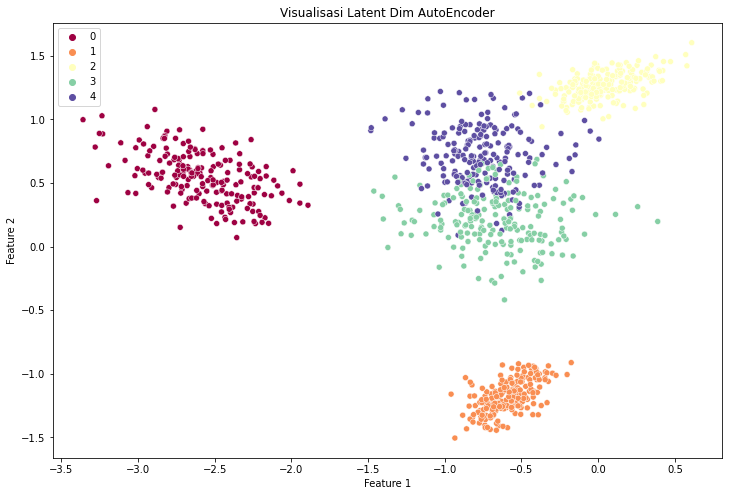

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Visualisasi Latent Dim AutoEncoder')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Kelas')
sns.scatterplot(feature_1, feature_2, hue=labels, palette='Spectral')

In [ ]:
real = []
encoded_images = []
decoded_images = []

for i in range(8):
  with torch.no_grad():
    mnistAutoencoder.eval()
    image = test_data[i][0]
    encoded = mnistAutoencoder.encode(image.view(1,1,28,28))
    decoded = mnistAutoencoder.decode(encoded)

    real.append(image)
    encoded_images.append(encoded)
    decoded_images.append(decoded)

In [ ]:
encoded_images[0].shape

torch.Size([1, 16, 22, 22])

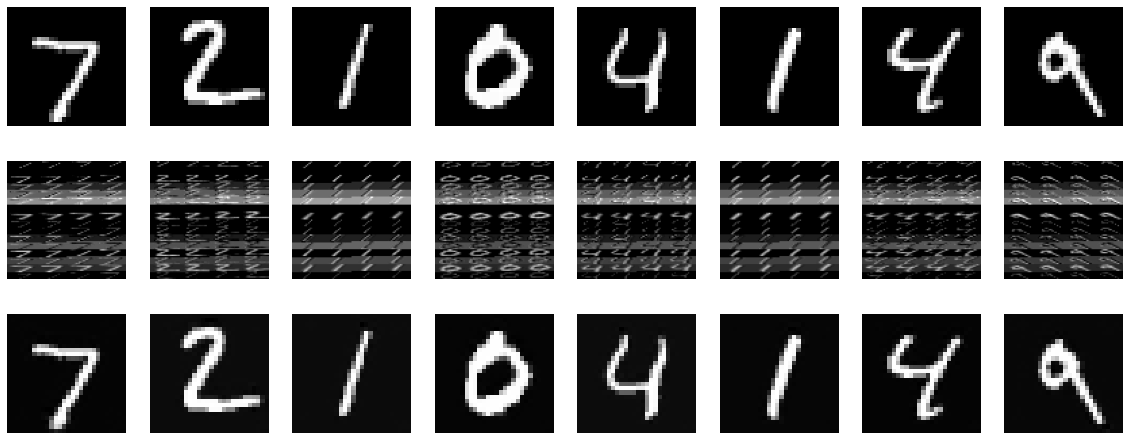

In [ ]:
fig, ax = plt.subplots(3, 8, figsize=(20,8))
for i in range(8):
  ax[0, i].imshow(real[i].view(28,28), cmap='gray')
  ax[0, i].axis('off')

  ax[1, i].imshow(encoded_images[i].view(88,88), cmap='gray')
  ax[1, i].axis('off')

  ax[2, i].imshow(decoded_images[i].view(28,28), cmap='gray')
  ax[2, i].axis('off')

In [ ]:
image, label = test_data[0]

In [ ]:
image.shape

torch.Size([1, 28, 28])

## No 1 Soal Arsitektur

In [ ]:
single_data = torch.FloatTensor([[1,0,0,1,0],
                                 [0,0,0,1,0],
                                 [1,0,1,0,1],
                                 [1,1,1,0,1],
                                 [0,1,0,1,0]])

single_data

tensor([[1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1.],
        [0., 1., 0., 1., 0.]])

In [ ]:
l1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
l2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, stride=2)

l3 = nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=3, stride=2)
l4 = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)

In [ ]:
res_l1 = l1(single_data.view(1, 1, 5, 5))
print(res_l1)
print(res_l1.shape)

tensor([[[[-0.5646, -0.2149, -1.0785],
          [-0.9415, -0.3974, -1.3192],
          [-0.3306, -1.1703, -0.2028]],

         [[ 0.6894,  0.6701,  0.2285],
          [ 0.6537,  0.7150,  0.1110],
          [ 0.4976, -0.0162,  0.5552]]]], grad_fn=<ThnnConv2DBackward>)
torch.Size([1, 2, 3, 3])


In [ ]:
res_l2 = l2(res_l1)
print(res_l2)
print(res_l2.shape)

tensor([[[[-0.0865]],

         [[ 0.5407]]]], grad_fn=<ThnnConv2DBackward>)
torch.Size([1, 2, 1, 1])


In [ ]:
res_l3 = l3(res_l2)
print(res_l3)
print(res_l3.shape)

tensor([[[[-0.2583, -0.2430, -0.4537],
          [-0.3835, -0.1716, -0.2255],
          [-0.3011, -0.4077, -0.4071]]]],
       grad_fn=<SlowConvTranspose2DBackward>)
torch.Size([1, 1, 3, 3])


In [ ]:
res_l4 = l4(res_l3)
print(res_l4)
print(res_l4.shape)

tensor([[[[-0.0583, -0.0890, -0.1193, -0.1890, -0.1828],
          [-0.0844, -0.0721, -0.1091,  0.0342, -0.0433],
          [-0.0990, -0.0598, -0.1262, -0.2760, -0.1495],
          [-0.1125, -0.1750, -0.0305,  0.0344, -0.0156],
          [-0.0705, -0.1620, -0.2109, -0.2373, -0.1060]]]],
       grad_fn=<SlowConvTranspose2DBackward>)
torch.Size([1, 1, 5, 5])


In [ ]:
# Konvolusi 1
conv1_1 = torch.FloatTensor([[6,2,6],
                             [4,6,4],
                             [6,6,4]])

conv1_2 = torch.FloatTensor([[3,3,2],
                             [5,3,4],
                             [5,3,5]])

conv1_1 = conv1_1+1
conv1_2 = conv1_2+2

res_conv_1_1 = torch.relu(conv1_1)
res_conv_1_2 = torch.relu(conv1_2)

print(res_conv_1_1)
print(res_conv_1_2)

tensor([[7., 3., 7.],
        [5., 7., 5.],
        [7., 7., 5.]])
tensor([[5., 5., 4.],
        [7., 5., 6.],
        [7., 5., 7.]])


In [ ]:
# Konvolusi 2
filter_2_1_1 = torch.FloatTensor([[0,1,0],
                                  [1,1,1],
                                  [0,0,0]])
filter_2_1_2 = torch.FloatTensor([[1,1,0],
                                  [0,0,1],
                                  [1,1,0]])


filter_2_2_1 = torch.FloatTensor([[2,2,0],
                                  [0,2,2],
                                  [-2,-1,0]])
filter_2_2_2 = torch.FloatTensor([[0,0,1],
                                  [1,1,0],
                                  [1,1,0]])

res_2_1_1 = torch.relu(F.conv2d(res_conv_1_1.view(1,1,3,3), filter_2_1_1.view(1,1,3,3)))+0
res_2_1_2 = torch.relu(F.conv2d(res_conv_1_1.view(1,1,3,3), filter_2_1_2.view(1,1,3,3)))+0

res_2_2_1 = torch.relu(F.conv2d(res_conv_1_2.view(1,1,3,3), filter_2_1_1.view(1,1,3,3)))+1
res_2_2_2 = torch.relu(F.conv2d(res_conv_1_2.view(1,1,3,3), filter_2_1_2.view(1,1,3,3)))+1

print(res_2_1_1)
print(res_2_1_2)
print()
print(res_2_2_1)
print(res_2_2_2)

tensor([[[[20.]]]])
tensor([[[[29.]]]])

tensor([[[[24.]]]])
tensor([[[[29.]]]])


In [ ]:
filter_3_1_1 = torch.FloatTensor([[3,0,3],
                                  [3,1,-1],
                                  [0,0,1]])
filter_3_1_2 = torch.FloatTensor([[2,1,6],
                                  [0,0,1],
                                  [1,0,1]])

res_3_1_1 = torch.relu(F.conv_transpose2d(res_2_1_1, filter_3_1_1.view(1,1,3,3), stride=2))
res_3_1_2 = torch.relu(F.conv_transpose2d(res_2_1_1, filter_3_1_2.view(1,1,3,3), stride=2))

res_3 = torch.cat([res_3_1_1, res_3_1_2], dim=1)
print(res_3)
print(res_3.shape)

tensor([[[[ 60.,   0.,  60.],
          [ 60.,  20.,   0.],
          [  0.,   0.,  20.]],

         [[ 40.,  20., 120.],
          [  0.,   0.,  20.],
          [ 20.,   0.,  20.]]]])
torch.Size([1, 2, 3, 3])


In [ ]:
result_last = torch.FloatTensor([[98,117,193,174,0],
                                 [60,80,-78,-19,-174],
                                 [19,19,-21,19,0],
                                 [0,0,-19,0,-39],
                                 [0,0,0,0,0]])

result_last = result_last+1
result_last

tensor([[  99.,  118.,  194.,  175.,    1.],
        [  61.,   81.,  -77.,  -18., -173.],
        [  20.,   20.,  -20.,   20.,    1.],
        [   1.,    1.,  -18.,    1.,  -38.],
        [   1.,    1.,    1.,    1.,    1.]])

In [ ]:
result_last = torch.tanh(result_last)

In [ ]:
result_last

tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  0.7616],
        [ 1.0000,  1.0000, -1.0000, -1.0000, -1.0000],
        [ 1.0000,  1.0000, -1.0000,  1.0000,  0.7616],
        [ 0.7616,  0.7616, -1.0000,  0.7616, -1.0000],
        [ 0.7616,  0.7616,  0.7616,  0.7616,  0.7616]])

In [ ]:
loss = nn.MSELoss()

In [ ]:
loss(result_last, single_data)

tensor(1.0874)

In [ ]:
transpconv_1 = torch.FloatTensor([[149,28,261],
                                  [93,31,0],
                                  [28,0,59]])

transpconv_2 = torch.FloatTensor([[130,29,246],
                                  [72,24,5],
                                  [29,0,53]])

In [ ]:
kernel = torch.FloatTensor([[1,1,0],
                            [0,0,-1],
                            [0,0,0]])

In [ ]:
res1 = F.conv_transpose2d(transpconv_1.view(1,1,3,3), kernel.view(1,1,3,3), stride=1)
res2 = F.conv_transpose2d(transpconv_2.view(1,1,3,3), kernel.view(1,1,3,3), stride=1)

res = res1+res2+1
print(res1)
print()
print(res2)
print()
print(res)

tensor([[[[ 149.,  177.,  289.,  261.,    0.],
          [  93.,  124., -118.,  -28., -261.],
          [  28.,   28.,  -34.,   28.,    0.],
          [   0.,    0.,  -28.,    0.,  -59.],
          [   0.,    0.,    0.,    0.,    0.]]]])

tensor([[[[ 130.,  159.,  275.,  246.,    0.],
          [  72.,   96., -101.,  -24., -246.],
          [  29.,   29.,  -19.,   29.,   -5.],
          [   0.,    0.,  -29.,    0.,  -53.],
          [   0.,    0.,    0.,    0.,    0.]]]])

tensor([[[[ 280.,  337.,  565.,  508.,    1.],
          [ 166.,  221., -218.,  -51., -506.],
          [  58.,   58.,  -52.,   58.,   -4.],
          [   1.,    1.,  -56.,    1., -111.],
          [   1.,    1.,    1.,    1.,    1.]]]])


In [ ]:
res = torch.tanh(res)
res

tensor([[[[ 1.0000,  1.0000,  1.0000,  1.0000,  0.7616],
          [ 1.0000,  1.0000, -1.0000, -1.0000, -1.0000],
          [ 1.0000,  1.0000, -1.0000,  1.0000, -0.9993],
          [ 0.7616,  0.7616, -1.0000,  0.7616, -1.0000],
          [ 0.7616,  0.7616,  0.7616,  0.7616,  0.7616]]]])

In [ ]:
losses = res - single_data
losses.abs()

tensor([[[[0.0000, 1.0000, 1.0000, 0.0000, 0.7616],
          [1.0000, 1.0000, 1.0000, 2.0000, 1.0000],
          [0.0000, 1.0000, 2.0000, 1.0000, 1.9993],
          [0.2384, 0.2384, 2.0000, 0.7616, 2.0000],
          [0.7616, 0.2384, 0.7616, 0.2384, 0.7616]]]])

In [ ]:
losses = losses**2
losses

tensor([[[[0.0000, 1.0000, 1.0000, 0.0000, 0.5800],
          [1.0000, 1.0000, 1.0000, 4.0000, 1.0000],
          [0.0000, 1.0000, 4.0000, 1.0000, 3.9973],
          [0.0568, 0.0568, 4.0000, 0.5800, 4.0000],
          [0.5800, 0.0568, 0.5800, 0.0568, 0.5800]]]])

In [ ]:
losses.sum()

tensor(31.1248)

In [ ]:
losses.sum()/25

tensor(1.2450)